# Capstone Project: The Battle of Neighborhoods - SG Edition (Food Court)

### 1. Introduction

In Singapore, food courts popular dining option for the locals. They consist of a number of food stalls operating in the same premise, and offer affordable everyday meals.

There are several key food courts operators in the market such as Koufu, Food Republic and Kopitiam. They operate as a chain for efficiency and cost effectiveness, but many of the food courts are similar and not well differentiated.

The Timbre Group is a relatively new entrant in the food court scene. It started off with bistros and restaurants business, and later on ventured into the food court market with its first food court Timbre+, which has a more modern and hip vibe as compared to other food courts. Timbre+ is located in Ayer Rajah neighbourhood, which is in postal district 05 in Singapore.

Suppose Timbre Group would like to replicate its modern food court concept, and they would like to find suitable neighbourhood for their second food court.

The ideal locations for the new food court should be neighbourhoods with other food and beverage venues (which is indicative of good foot fall) but have fewer food court businesses.

### 2. Data

1. List of Singapore postal districts/ neighbouhoods from https://en.wikipedia.org/wiki/Postal_codes_in_Singapore.

2. Geographical coordinates of each neighborhood (in excel format)

3. Venue information from Foursquare API

### 3. Methodology

Import the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### 3.1 Fetch data on postal districts in Singapore

Fetch the list of postal districts in Singapore from Wikipedia using BeautifulSoup package.

In [2]:
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'

html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

tr_list = soup.find('table', class_='wikitable').find_all('tr')
len(tr_list)

29

Create the dataframe for postal districts.

In [3]:
column_names = ['PostalDist', 'PostalSector', 'Neighborhood']
df = pd.DataFrame(columns=column_names)

for tr in tr_list[1:]:
    td_list = [td for td in tr.contents if td != '\n']
    
    postal_dist = td_list[0].text.replace('\n', '')
    postal_sector = td_list[1].text.replace('\n', '')
    neig = td_list[2].text.replace('\n', '')
    
    df = df.append({'PostalDist': postal_dist,
               'PostalSector': postal_sector,
               'Neighborhood': neig
              }
              ,ignore_index=True
             )
    
df.head()

,PostalDist,PostalSector,Neighborhood
0,01,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,02,"07, 08","Anson, Tanjong Pagar"
2,03,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,04,"09, 10","Telok Blangah, Harbourfront"
4,05,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


In [4]:
df.shape

(28, 3)

In [5]:
df.dtypes

PostalDist      object
PostalSector    object
Neighborhood    object
dtype: object

Since PostalDist is an object, let's change it to integer.

In [6]:
df['PostalDist'] = df['PostalDist'].astype(int)

In [7]:
df.dtypes

PostalDist       int64
PostalSector    object
Neighborhood    object
dtype: object

In [8]:
df.head()

,PostalDist,PostalSector,Neighborhood
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


### 3.2 Get geographical data of postal districts

Load geographical data.

In [9]:
# The code was removed by Watson Studio for sharing.

,Postcode,Latitude,Longitude
0,1,1.279114,103.851259
1,2,1.276904,103.843854
2,3,1.306456,103.794766
3,4,1.279457,103.817898
4,5,1.285272,103.779117


In [10]:
geo_df.dtypes

Postcode       int64
Latitude     float64
Longitude    float64
dtype: object

In [11]:
geo_df.rename(columns={'Postcode': 'PostalDist'}, inplace=True)

sg_df = pd.merge(df, geo_df, on='PostalDist')
sg_df.head(10)

,PostalDist,PostalSector,Neighborhood,Latitude,Longitude
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259
1,2,"07, 08","Anson, Tanjong Pagar",1.276904,103.843854
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.306456,103.794766
3,4,"09, 10","Telok Blangah, Harbourfront",1.279457,103.817898
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.285272,103.779117
5,6,17,"High Street, Beach Road (part)",1.290228,103.850750
6,7,"18, 19","Middle Road, Golden Mile",1.303207,103.850493
7,8,"20, 21","Little India, Farrer Park, Jalan Besar, Lavender",1.307582,103.858967
8,9,"22, 23","Orchard, Cairnhill, River Valley",1.299351,103.848675
9,10,"24, 25, 26, 27","Ardmore, Bukit Timah, Holland Road, Tanglin",1.304915,103.808267


The geographical coordinates of Singapore is 1.290270, 103.851959.
Let's use it to create a map of Singapore.

In [12]:
latitude = 1.290270
longitude = 103.851959

# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(sg_df['Latitude'], sg_df['Longitude'], sg_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

### 3.3 Fetch data from Foursquare API

First, define Foursquare credentials (hidden cell).

In [13]:
# The code was removed by Watson Studio for sharing.

Explore top 100 venues in each neighborhood within 500m radius.

In [14]:
LIMIT = 100
radius = 500

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
sg_venues = getNearbyVenues(names=sg_df['Neighborhood'],
                                   latitudes=sg_df['Latitude'],
                                   longitudes=sg_df['Longitude']
                                  )

Raffles Place, Cecil, Marina, People's Park
Anson, Tanjong Pagar
Bukit Merah, Queenstown, Tiong Bahru
Telok Blangah, Harbourfront
Pasir Panjang, Hong Leong Garden, Clementi New Town
High Street, Beach Road (part)
Middle Road, Golden Mile
Little India, Farrer Park, Jalan Besar, Lavender
Orchard, Cairnhill, River Valley
Ardmore, Bukit Timah, Holland Road, Tanglin
Watten Estate, Novena, Thomson
Balestier, Toa Payoh, Serangoon
Macpherson, Braddell
Geylang, Eunos
Katong, Joo Chiat, Amber Road
Bedok, Upper East Coast, Eastwood, Kew Drive
Loyang, Changi
Simei, Tampines, Pasir Ris
Serangoon Garden, Hougang, Punggol
Bishan, Ang Mo Kio
Upper Bukit Timah, Clementi Park, Ulu Pandan
Jurong, Tuas
Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang
Lim Chu Kang, Tengah
Kranji, Woodgrove, Woodlands
Upper Thomson, Springleaf
Yishun, Sembawang
Seletar


In [17]:
print(sg_venues.shape)
sg_venues.head()

(879, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Pure Fitness,1.278631,103.851487,Gym
1,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,The Westin Singapore,1.278275,103.850772,Hotel
2,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Lau Pa Sat Satay Street,1.280261,103.850235,Street Food Gathering
3,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Sofitel So Singapore,1.280124,103.849867,Hotel
4,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Lobby Lounge Westin,1.277811,103.850966,Bar


In [18]:
sg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Anson, Tanjong Pagar",100,100,100,100,100,100
"Ardmore, Bukit Timah, Holland Road, Tanglin",44,44,44,44,44,44
"Balestier, Toa Payoh, Serangoon",27,27,27,27,27,27
"Bedok, Upper East Coast, Eastwood, Kew Drive",12,12,12,12,12,12
"Bishan, Ang Mo Kio",23,23,23,23,23,23
"Bukit Merah, Queenstown, Tiong Bahru",35,35,35,35,35,35
"Geylang, Eunos",19,19,19,19,19,19
"High Street, Beach Road (part)",85,85,85,85,85,85
"Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang",32,32,32,32,32,32


In [19]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 188 uniques categories.


Use onehot key to segregate the venue categories into columns.

In [20]:
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Building,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,History Museum,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Park,Peking Duck Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Temple,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Raffles Place, Cecil, Marina, Peop

In [21]:
sg_onehot.shape

(879, 189)

In [22]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped

,Neighborhood,Accessories Store,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bike Trail,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Building,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dumpling Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Harbor / Marina,History Museum,Hong Kong Restaurant,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Paella Restaurant,Park,Peking Duck Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Ramen Restaurant,Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shopping Mall,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Temple,Thai Restaurant,Theater,Theme Park,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Anson, Tanjong Pagar",0.000000,0.010000,0.010000,0.000000,0.000000,0.020000,0.000,0.010000,0.010000,0.01,0.060000,0.020000,0.00000,0.00,0.020000,0.000000,0.000,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.010000,0.000000,0.000000,0.040000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.01,0.000000,0.010000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.020000,0.000000,0.010,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.050000,0.090000,0.000000,0.000000,0.01,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020000,0.000000,0.0,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.05,0.00,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,

In [23]:
sg_grouped.shape

(27, 189)

### 3.4 Explore top 10 common venues in each neighborhood

Create dataframe to show top 10 common venues in each neighborhood.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anson, Tanjong Pagar",Japanese Restaurant,Coffee Shop,Bakery,Italian Restaurant,Ramen Restaurant,Hotel,Café,Cocktail Bar,Korean Restaurant,Tapas Restaurant
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Bar,Café,Spanish Restaurant,Lounge,Wine Bar,Modern European Restaurant,Gastropub,Ice Cream Shop,Indian Restaurant,Seafood Restaurant
2,"Balestier, Toa Payoh, Serangoon",Noodle House,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Food Court,Steakhouse,Thai Restaurant,Convenience Store,Grocery Store,Park
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Chinese Restaurant,Bakery,French Restaurant,Sports Bar,Bus Stop,Food Court,Fast Food Restaurant,Sandwich Place,Noodle House,Bubble Tea Shop
4,"Bishan, Ang Mo Kio",Chinese Restaurant,Food Court,Supermarket,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,General Entertainment,Noodle House,Pharmacy,Soup Place


### 3.5 Cluster the neighborhoods

To cluster the neighborhoods using k-means clustering, let's use the elbow method to identify the optimal k.

In [54]:
sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

In [55]:
inertias = [] 
K = range(1,15) 

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sg_grouped_clustering)
    inertias.append(km.inertia_)

inertias

[2.423804749575864,
 2.0357936600923887,
 1.5983430666853606,
 1.3069247950390281,
 1.136149466709231,
 0.989427603023727,
 0.8808137224499432,
 0.8606317141713932,
 0.7093798405917134,
 0.614935523552729,
 0.5553209991755186,
 0.4933266965075403,
 0.4348802774134028,
 0.3829625884308675]

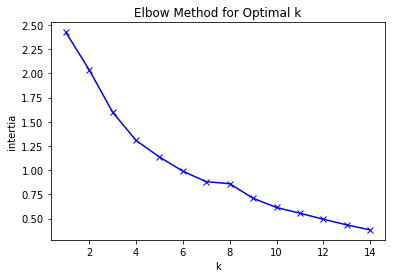

In [56]:
import matplotlib.pyplot as plt 

plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('intertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Based on the plot, k = 6 is the "elbow" point after which the inertia starts decreasing in a linear fashion. 
As such, we will based on k-means clustering model using k=6.

In [57]:
kclusters = 6

sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:28]

array([1, 1, 4, 1, 4, 1, 1, 1, 4, 5, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 0, 5,
       1, 1, 4, 2, 0], dtype=int32)

In [58]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = sg_df

sg_merged = sg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sg_merged.head()

,PostalDist,PostalSector,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,1.0,Café,Coffee Shop,Chinese Restaurant,Salad Place,Restaurant,Hotel,Cocktail Bar,Italian Restaurant,Japanese Restaurant,Korean Restaurant
1,2,"07, 08","Anson, Tanjong Pagar",1.276904,103.843854,1.0,Japanese Restaurant,Coffee Shop,Bakery,Italian Restaurant,Ramen Restaurant,Hotel,Café,Cocktail Bar,Korean Restaurant,Tapas Restaurant
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.306456,103.794766,1.0,Bakery,Coffee Shop,Sandwich Place,Indian Restaurant,Asian Restaurant,Salad Place,Café,Sushi Restaurant,Gastropub,Fast Food Restaurant
3,4,"09, 10","Telok Blangah, Harbourfront",1.279457,103.817898,1.0,Chinese Restaurant,Coffee Shop,Food Court,Bus Line,Noodle House,Bowling Alley,Clothing Store,Club House,Fast Food Restaurant,Supermarket
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.285272,103.779117,1.0,Miscellaneous Shop,Outdoor Sculpture,Bus Station,Food Court,Metro Station,Sculpture Garden,Theme Park,Coffee Shop,Korean Restaurant,Pet Store


To visualise the clusters.

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['Neighborhood'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4. Results

Let's explore each cluster.

#### Cluster 1 (Label 0, Red)

In [62]:
sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


#### Cluster 2 (Label 1, Purple)

In [ ]:
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

#### Cluster 3 (Label 2, Blue)

In [ ]:
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

#### Cluster 4 (Label 3, Cyan)

In [ ]:
sg_merged.loc[sg_merged['Cluster Labels'] == 3, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

#### Cluster 5 (Label 4, Green)

In [ ]:
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

#### Cluster 6 (Label 5, Orange)

In [ ]:
sg_merged.loc[sg_merged['Cluster Labels'] == 5, sg_merged.columns[[0] + [2] + list(range(5, sg_merged.shape[1]))]]

### 5. Discussion

In this section, I would be discussion the key observations based on the k-mean clusters and provide my recommendation based on the results.

Cluster 1, Cluster 2 and Cluster 3 contain neighbourhoods which have food and beverages outlets as their top common venues. 

Cluster 4, Cluster 5 and Cluster 6 have neighbourhoods with very specific types of venues as listed below and are not ideal locations for Timbre+ to launch its new food court:

* Cluster 4: Gym, military base
* Cluster 5: Playground
* Cluster 6: Campground

Examining Cluster 1, it is noted that “Food Court” appeared as one of the top 5 most common venues in all neighbourhoods with the exception of Pasir Panjang and Serangoon Garden. The high density of food courts means these are neighbourhood with high competition, and it would be risky for Timbre+ to open its new food court in these neighbourhood.

Cluster 2 and Cluster 3 tend to have other types of food and beverage outlets, which may be potential areas that Timbre+ can consider.
This analysis is performed on limited data available for Singapore. The analysis may yield better results if there is greater adoption and usage of Foursquare in the Singapore market.


### 6. Conclusion

Using Foursquare API, I can obtain data of common places in Singapore to:

* Identify the similarity or dissimilarity of different neighbourhoods
* Cluster the neighbourhoods based on commonality

I can then use such analysis as one of my input to assess areas which may have good potential for new business in addition to other market and financial data.
